## Drive Mount

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"


import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from keras import ops
from keras import layers

from glob import glob


## Data Preprocessing
Takes raw dataset files (original images, their corresponding segmentation maps, and class label masks), processes them into a uniform format, and returns them as a ready-to-use TensorFlow Dataset object for training a segmentation model.

In [ ]:
import tensorflow as tf
import numpy as np

# Config
BATCH_SIZE = 4
IMG_HEIGHT = IMG_WIDTH = 256
NUM_CLASSES = 21  # PASCAL VOC has 21 classes including background
AUTOTUNE = tf.data.AUTOTUNE

def load(image_files, batch_size, is_train=True):
    def _random_crop(segmentation_map, image, labels, crop_size=(IMG_HEIGHT, IMG_WIDTH)):
        crop_size = tf.convert_to_tensor(crop_size)
        image_shape = tf.shape(image)[:2]
        margins = image_shape - crop_size
        y1 = tf.random.uniform(shape=(), maxval=margins[0]+1, dtype=tf.int32)
        x1 = tf.random.uniform(shape=(), maxval=margins[1]+1, dtype=tf.int32)
        y2 = y1 + crop_size[0]
        x2 = x1 + crop_size[1]
        cropped_images = []
        for img in [segmentation_map, image, labels]:
            cropped_images.append(img[y1:y2, x1:x2])
        return tuple(cropped_images)

    def _load_data_tf(image_file, segmentation_map_file, label_file):
        # Load images
        image = tf.image.decode_png(tf.io.read_file(image_file), channels=3)
        segmentation_map = tf.image.decode_png(tf.io.read_file(segmentation_map_file), channels=3)
        labels = tf.image.decode_bmp(tf.io.read_file(label_file), channels=3)

        # Convert label image to single-channel by taking one (they're all equal)
        labels = labels[..., 0]

        # ✅ Resize everything a bit larger than crop size to ensure valid random crop
        resize_size = IMG_HEIGHT + 32  # 256 + 32 = 288
        image = tf.image.resize(image, [resize_size, resize_size])
        segmentation_map = tf.image.resize(segmentation_map, [resize_size, resize_size])
        labels = tf.image.resize(labels[..., tf.newaxis], [resize_size, resize_size], method='nearest')
        labels = tf.squeeze(labels, axis=-1)

        # Normalize input images to [-1, 1]
        image = tf.cast(image, tf.float32) / 127.5 - 1
        segmentation_map = tf.cast(segmentation_map, tf.float32) / 127.5 - 1
        return segmentation_map, image, labels

    def _one_hot(segmentation_map, image, labels):
        # Replace void (255) with class 0 for safe one-hot encoding
        mask = tf.not_equal(labels, 255)
        labels = tf.where(mask, labels, tf.zeros_like(labels))
        labels = tf.one_hot(labels, NUM_CLASSES)
        labels.set_shape((None, None, NUM_CLASSES))
        return segmentation_map, image, labels

    # Infer file paths
    segmentation_map_files = [
        image_file.replace("images", "segmentation_map").replace("jpg", "png")
        for image_file in image_files
    ]
    label_files = [
        image_file.replace("images", "segmentation_labels").replace("jpg", "bmp")
        for image_file in image_files
    ]

    # Build dataset
    dataset = tf.data.Dataset.from_tensor_slices((image_files, segmentation_map_files, label_files))
    if is_train:
        dataset = dataset.shuffle(batch_size * 10)

    dataset = dataset.map(_load_data_tf, num_parallel_calls=AUTOTUNE)
    dataset = dataset.map(_random_crop, num_parallel_calls=AUTOTUNE)
    dataset = dataset.map(_one_hot, num_parallel_calls=AUTOTUNE)
    dataset = dataset.batch(batch_size, drop_remainder=True)
    dataset = dataset.prefetch(AUTOTUNE)

    return dataset


## Dataset Loading and Train-Test Split

In [ ]:
# PATH =  "/content/drive/MyDrive/Pascal_VOC_Facade_Format/VOC2012_facades/images/"
# SPLIT = 0.2

# files = glob(PATH + "*.jpg")
# np.random.shuffle(files)

# split_index = int(len(files) * (1 - SPLIT))
# train_files = files[:split_index]
# val_files = files[split_index:]

# print(f"Total samples: {len(files)}.")
# print(f"Total training samples: {len(train_files)}.")
# print(f"Total validation samples: {len(val_files)}.")
# Load file paths
PATH = "/content/drive/MyDrive/Pascal_VOC_Facade_Format/VOC2012_facades/images/"
SPLIT = 0.2

files = glob(PATH + "*.jpg")
np.random.shuffle(files)

split_index = int(len(files) * (1 - SPLIT))
train_files = files[:split_index]
val_files = files[split_index:]

# Load datasets
train_dataset = load(train_files, batch_size=BATCH_SIZE, is_train=True)
val_dataset = load(val_files, batch_size=BATCH_SIZE, is_train=False)
print(f"Total samples: {len(files)}.")
print(f"Total training samples: {len(train_files)}.")
print(f"Total validation samples: {len(val_files)}.")

Total samples: 2913.
Total training samples: 2330.
Total validation samples: 583.


## Plot Some Segmentation Maps and Corresponding Real Images

Segmentation map batch shape: (4, 256, 256, 3).
Image batch shape: (4, 256, 256, 3).
One-hot encoded label map shape: (4, 256, 256, 21).


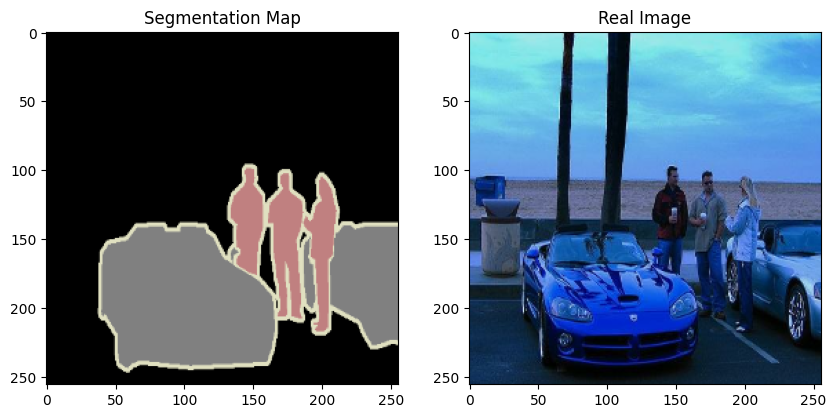

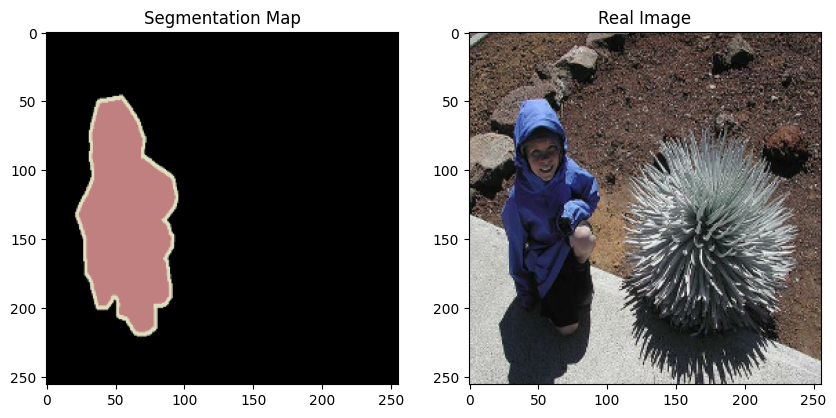

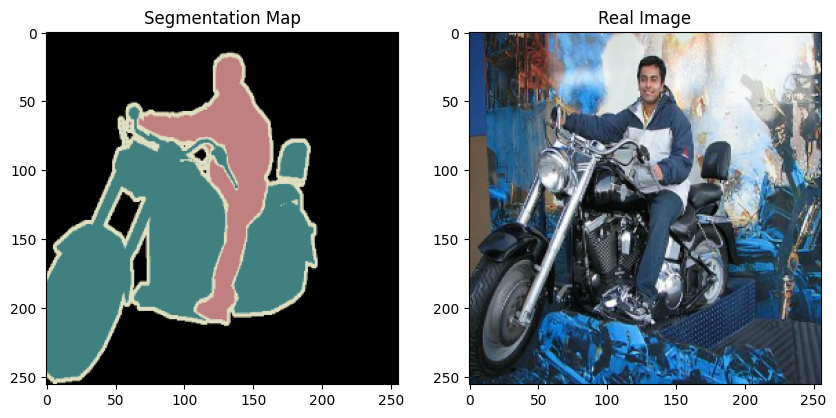

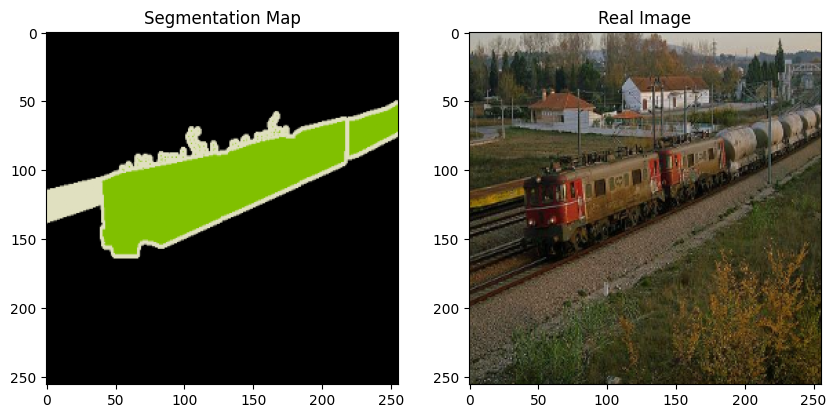

In [ ]:
sample_train_batch = next(iter(train_dataset))
print(f"Segmentation map batch shape: {sample_train_batch[0].shape}.")
print(f"Image batch shape: {sample_train_batch[1].shape}.")
print(f"One-hot encoded label map shape: {sample_train_batch[2].shape}.")

# Plot a view samples from the training set.
for segmentation_map, real_image in zip(sample_train_batch[0], sample_train_batch[1]):
    fig = plt.figure(figsize=(10, 10))
    fig.add_subplot(1, 2, 1).set_title("Segmentation Map")
    plt.imshow((segmentation_map + 1) / 2)
    fig.add_subplot(1, 2, 2).set_title("Real Image")
    plt.imshow((real_image + 1) / 2)
    plt.show()

## Define SPADE block, Residual block and Gaussian Sampler block

In [ ]:

class SPADE(layers.Layer):
    def __init__(self, filters, epsilon=1e-5, **kwargs):
        super().__init__(**kwargs)
        self.epsilon = epsilon
        self.conv = layers.Conv2D(128, 3, padding="same", activation="relu")
        self.conv_gamma = layers.Conv2D(filters, 3, padding="same")
        self.conv_beta = layers.Conv2D(filters, 3, padding="same")

    def build(self, input_shape):
        self.resize_shape = input_shape[1:3]

    def call(self, input_tensor, raw_mask):
        mask = ops.image.resize(raw_mask, self.resize_shape, interpolation="nearest")
        x = self.conv(mask)
        gamma = self.conv_gamma(x)
        beta = self.conv_beta(x)
        mean, var = ops.moments(input_tensor, axes=(0, 1, 2), keepdims=True)
        std = ops.sqrt(var + self.epsilon)
        normalized = (input_tensor - mean) / std
        output = gamma * normalized + beta
        return output


class ResBlock(layers.Layer):
    def __init__(self, filters, **kwargs):
        super().__init__(**kwargs)
        self.filters = filters

    def build(self, input_shape):
        input_filter = input_shape[-1]
        self.spade_1 = SPADE(input_filter)
        self.spade_2 = SPADE(self.filters)
        self.conv_1 = layers.Conv2D(self.filters, 3, padding="same")
        self.conv_2 = layers.Conv2D(self.filters, 3, padding="same")
        self.learned_skip = False

        if self.filters != input_filter:
            self.learned_skip = True
            self.spade_3 = SPADE(input_filter)
            self.conv_3 = layers.Conv2D(self.filters, 3, padding="same")

    def call(self, input_tensor, mask):
        x = self.spade_1(input_tensor, mask)
        x = self.conv_1(keras.activations.leaky_relu(x, 0.2))
        x = self.spade_2(x, mask)
        x = self.conv_2(keras.activations.leaky_relu(x, 0.2))
        skip = (
            self.conv_3(
                keras.activations.leaky_relu(self.spade_3(input_tensor, mask), 0.2)
            )
            if self.learned_skip
            else input_tensor
        )
        output = skip + x
        return output


class GaussianSampler(layers.Layer):
    def __init__(self, batch_size, latent_dim, **kwargs):
        super().__init__(**kwargs)
        self.batch_size = batch_size
        self.latent_dim = latent_dim
        self.seed_generator = keras.random.SeedGenerator(1337)

    def call(self, inputs):
        means, variance = inputs
        epsilon = keras.random.normal(
            shape=(self.batch_size, self.latent_dim),
            mean=0.0,
            stddev=1.0,
            seed=self.seed_generator,
        )
        samples = means + ops.exp(0.5 * variance) * epsilon
        return samples


## Define Downsampling function

In [ ]:

def downsample(
    channels,
    kernels,
    strides=2,
    apply_norm=True,
    apply_activation=True,
    apply_dropout=False,
):
    block = keras.Sequential()
    block.add(
        layers.Conv2D(
            channels,
            kernels,
            strides=strides,
            padding="same",
            use_bias=False,
            kernel_initializer=keras.initializers.GlorotNormal(),
        )
    )
    if apply_norm:
        block.add(layers.GroupNormalization(groups=-1))
    if apply_activation:
        block.add(layers.LeakyReLU(0.2))
    if apply_dropout:
        block.add(layers.Dropout(0.5))
    return block


## Define Encoder

In [ ]:

def build_encoder(image_shape, encoder_downsample_factor=64, latent_dim=256):
    input_image = keras.Input(shape=image_shape)
    x = downsample(encoder_downsample_factor, 3, apply_norm=False)(input_image)
    x = downsample(2 * encoder_downsample_factor, 3)(x)
    x = downsample(4 * encoder_downsample_factor, 3)(x)
    x = downsample(8 * encoder_downsample_factor, 3)(x)
    x = downsample(8 * encoder_downsample_factor, 3)(x)
    x = layers.Flatten()(x)
    mean = layers.Dense(latent_dim, name="mean")(x)
    variance = layers.Dense(latent_dim, name="variance")(x)
    return keras.Model(input_image, [mean, variance], name="encoder")


## Define Generator

In [ ]:

def build_generator(mask_shape, latent_dim=256):
    latent = keras.Input(shape=(latent_dim,))
    mask = keras.Input(shape=mask_shape)
    x = layers.Dense(16384)(latent)
    x = layers.Reshape((4, 4, 1024))(x)
    x = ResBlock(filters=1024)(x, mask)
    x = layers.UpSampling2D((2, 2))(x)
    x = ResBlock(filters=1024)(x, mask)
    x = layers.UpSampling2D((2, 2))(x)
    x = ResBlock(filters=1024)(x, mask)
    x = layers.UpSampling2D((2, 2))(x)
    x = ResBlock(filters=512)(x, mask)
    x = layers.UpSampling2D((2, 2))(x)
    x = ResBlock(filters=256)(x, mask)
    x = layers.UpSampling2D((2, 2))(x)
    x = ResBlock(filters=128)(x, mask)
    x = layers.UpSampling2D((2, 2))(x)
    x = keras.activations.leaky_relu(x, 0.2)
    output_image = keras.activations.tanh(layers.Conv2D(3, 4, padding="same")(x))
    return keras.Model([latent, mask], output_image, name="generator")


## Define Discriminator

In [ ]:

def build_discriminator(image_shape, downsample_factor=64):
    input_image_A = keras.Input(shape=image_shape, name="discriminator_image_A")
    input_image_B = keras.Input(shape=image_shape, name="discriminator_image_B")
    x = layers.Concatenate()([input_image_A, input_image_B])
    x1 = downsample(downsample_factor, 4, apply_norm=False)(x)
    x2 = downsample(2 * downsample_factor, 4)(x1)
    x3 = downsample(4 * downsample_factor, 4)(x2)
    x4 = downsample(8 * downsample_factor, 4, strides=1)(x3)
    x5 = layers.Conv2D(1, 4)(x4)
    outputs = [x1, x2, x3, x4, x5]
    return keras.Model([input_image_A, input_image_B], outputs)


## Define all Loss Functions

In [ ]:

def generator_loss(y):
    return -ops.mean(y)


def kl_divergence_loss(mean, variance):
    return -0.5 * ops.sum(1 + variance - ops.square(mean) - ops.exp(variance))


class FeatureMatchingLoss(keras.losses.Loss):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.mae = keras.losses.MeanAbsoluteError()

    def call(self, y_true, y_pred):
        loss = 0
        for i in range(len(y_true) - 1):
            loss += self.mae(y_true[i], y_pred[i])
        return loss


class VGGFeatureMatchingLoss(keras.losses.Loss):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.encoder_layers = [
            "block1_conv1",
            "block2_conv1",
            "block3_conv1",
            "block4_conv1",
            "block5_conv1",
        ]
        self.weights = [1.0 / 32, 1.0 / 16, 1.0 / 8, 1.0 / 4, 1.0]
        vgg = keras.applications.VGG19(include_top=False, weights="imagenet")
        layer_outputs = [vgg.get_layer(x).output for x in self.encoder_layers]
        self.vgg_model = keras.Model(vgg.input, layer_outputs, name="VGG")
        self.mae = keras.losses.MeanAbsoluteError()

    def call(self, y_true, y_pred):
        y_true = keras.applications.vgg19.preprocess_input(127.5 * (y_true + 1))
        y_pred = keras.applications.vgg19.preprocess_input(127.5 * (y_pred + 1))
        real_features = self.vgg_model(y_true)
        fake_features = self.vgg_model(y_pred)
        loss = 0
        for i in range(len(real_features)):
            loss += self.weights[i] * self.mae(real_features[i], fake_features[i])
        return loss


class DiscriminatorLoss(keras.losses.Loss):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.hinge_loss = keras.losses.Hinge()

    def call(self, y, is_real):
        return self.hinge_loss(is_real, y)


## During the training of GAN, Plot loss values in each step and also to see how the generated images improve over epochs.

In [ ]:

class GanMonitor(keras.callbacks.Callback):
    def __init__(self, val_dataset, n_samples, epoch_interval=5):
        self.val_images = next(iter(val_dataset))
        self.n_samples = n_samples
        self.epoch_interval = epoch_interval
        self.seed_generator = keras.random.SeedGenerator(42)

    def infer(self):
        latent_vector = keras.random.normal(
            shape=(self.model.batch_size, self.model.latent_dim),
            mean=0.0,
            stddev=2.0,
            seed=self.seed_generator,
        )
        return self.model.predict([latent_vector, self.val_images[2]])

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.epoch_interval == 0:
            generated_images = self.infer()
            for _ in range(self.n_samples):
                grid_row = min(generated_images.shape[0], 3)
                f, axarr = plt.subplots(grid_row, 3, figsize=(18, grid_row * 6))
                for row in range(grid_row):
                    ax = axarr if grid_row == 1 else axarr[row]
                    ax[0].imshow((self.val_images[0][row] + 1) / 2)
                    ax[0].axis("off")
                    ax[0].set_title("Mask", fontsize=20)
                    ax[1].imshow((self.val_images[1][row] + 1) / 2)
                    ax[1].axis("off")
                    ax[1].set_title("Ground Truth", fontsize=20)
                    ax[2].imshow((generated_images[row] + 1) / 2)
                    ax[2].axis("off")
                    ax[2].set_title("Generated", fontsize=20)
                plt.show()


## GAN Training

In [ ]:

class GauGAN(keras.Model):
    def __init__(
        self,
        image_size,
        num_classes,
        batch_size,
        latent_dim,
        feature_loss_coeff=10,
        vgg_feature_loss_coeff=0.1,
        kl_divergence_loss_coeff=0.1,
        **kwargs,
    ):
        super().__init__(**kwargs)

        self.image_size = image_size
        self.latent_dim = latent_dim
        self.batch_size = batch_size
        self.num_classes = num_classes
        self.image_shape = (image_size, image_size, 3)
        self.mask_shape = (image_size, image_size, num_classes)
        self.feature_loss_coeff = feature_loss_coeff
        self.vgg_feature_loss_coeff = vgg_feature_loss_coeff
        self.kl_divergence_loss_coeff = kl_divergence_loss_coeff

        self.discriminator = build_discriminator(self.image_shape)
        self.generator = build_generator(self.mask_shape)
        self.encoder = build_encoder(self.image_shape)
        self.sampler = GaussianSampler(batch_size, latent_dim)
        self.patch_size, self.combined_model = self.build_combined_generator()

        self.disc_loss_tracker = keras.metrics.Mean(name="disc_loss")
        self.gen_loss_tracker = keras.metrics.Mean(name="gen_loss")
        self.feat_loss_tracker = keras.metrics.Mean(name="feat_loss")
        self.vgg_loss_tracker = keras.metrics.Mean(name="vgg_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.disc_loss_tracker,
            self.gen_loss_tracker,
            self.feat_loss_tracker,
            self.vgg_loss_tracker,
            self.kl_loss_tracker,
        ]

    def build_combined_generator(self):
        # This method builds a model that takes as inputs the following:
        # latent vector, one-hot encoded segmentation label map, and
        # a segmentation map. It then (i) generates an image with the generator,
        # (ii) passes the generated images and segmentation map to the discriminator.
        # Finally, the model produces the following outputs: (a) discriminator outputs,
        # (b) generated image.
        # We will be using this model to simplify the implementation.
        self.discriminator.trainable = False
        mask_input = keras.Input(shape=self.mask_shape, name="mask")
        image_input = keras.Input(shape=self.image_shape, name="image")
        latent_input = keras.Input(shape=(self.latent_dim,), name="latent")
        generated_image = self.generator([latent_input, mask_input])
        discriminator_output = self.discriminator([image_input, generated_image])
        combined_outputs = discriminator_output + [generated_image]
        patch_size = discriminator_output[-1].shape[1]
        combined_model = keras.Model(
            [latent_input, mask_input, image_input], combined_outputs
        )
        return patch_size, combined_model

    def compile(self, gen_lr=1e-4, disc_lr=4e-4, **kwargs):
        super().compile(**kwargs)
        self.generator_optimizer = keras.optimizers.Adam(
            gen_lr, beta_1=0.0, beta_2=0.999
        )
        self.discriminator_optimizer = keras.optimizers.Adam(
            disc_lr, beta_1=0.0, beta_2=0.999
        )
        self.discriminator_loss = DiscriminatorLoss()
        self.feature_matching_loss = FeatureMatchingLoss()
        self.vgg_loss = VGGFeatureMatchingLoss()

    def train_discriminator(self, latent_vector, segmentation_map, real_image, labels):
        fake_images = self.generator([latent_vector, labels])
        with tf.GradientTape() as gradient_tape:
            pred_fake = self.discriminator([segmentation_map, fake_images])[-1]
            pred_real = self.discriminator([segmentation_map, real_image])[-1]
            loss_fake = self.discriminator_loss(pred_fake, -1.0)
            loss_real = self.discriminator_loss(pred_real, 1.0)
            total_loss = 0.5 * (loss_fake + loss_real)

        self.discriminator.trainable = True
        gradients = gradient_tape.gradient(
            total_loss, self.discriminator.trainable_variables
        )
        self.discriminator_optimizer.apply_gradients(
            zip(gradients, self.discriminator.trainable_variables)
        )
        return total_loss

    def train_generator(
        self, latent_vector, segmentation_map, labels, image, mean, variance
    ):
        # Generator learns through the signal provided by the discriminator. During
        # backpropagation, we only update the generator parameters.
        self.discriminator.trainable = False
        with tf.GradientTape() as tape:
            real_d_output = self.discriminator([segmentation_map, image])
            combined_outputs = self.combined_model(
                [latent_vector, labels, segmentation_map]
            )
            fake_d_output, fake_image = combined_outputs[:-1], combined_outputs[-1]
            pred = fake_d_output[-1]

            # Compute generator losses.
            g_loss = generator_loss(pred)
            kl_loss = self.kl_divergence_loss_coeff * kl_divergence_loss(mean, variance)
            vgg_loss = self.vgg_feature_loss_coeff * self.vgg_loss(image, fake_image)
            feature_loss = self.feature_loss_coeff * self.feature_matching_loss(
                real_d_output, fake_d_output
            )
            total_loss = g_loss + kl_loss + vgg_loss + feature_loss

        all_trainable_variables = (
            self.combined_model.trainable_variables + self.encoder.trainable_variables
        )

        gradients = tape.gradient(total_loss, all_trainable_variables)
        self.generator_optimizer.apply_gradients(
            zip(gradients, all_trainable_variables)
        )
        return total_loss, feature_loss, vgg_loss, kl_loss

    def train_step(self, data):
        segmentation_map, image, labels = data
        mean, variance = self.encoder(image)
        latent_vector = self.sampler([mean, variance])
        discriminator_loss = self.train_discriminator(
            latent_vector, segmentation_map, image, labels
        )
        (generator_loss, feature_loss, vgg_loss, kl_loss) = self.train_generator(
            latent_vector, segmentation_map, labels, image, mean, variance
        )

        # Report progress.
        self.disc_loss_tracker.update_state(discriminator_loss)
        self.gen_loss_tracker.update_state(generator_loss)
        self.feat_loss_tracker.update_state(feature_loss)
        self.vgg_loss_tracker.update_state(vgg_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        results = {m.name: m.result() for m in self.metrics}
        return results

    def test_step(self, data):
        segmentation_map, image, labels = data
        # Obtain the learned moments of the real image distribution.
        mean, variance = self.encoder(image)

        # Sample a latent from the distribution defined by the learned moments.
        latent_vector = self.sampler([mean, variance])

        # Generate the fake images.
        fake_images = self.generator([latent_vector, labels])

        # Calculate the losses.
        pred_fake = self.discriminator([segmentation_map, fake_images])[-1]
        pred_real = self.discriminator([segmentation_map, image])[-1]
        loss_fake = self.discriminator_loss(pred_fake, -1.0)
        loss_real = self.discriminator_loss(pred_real, 1.0)
        total_discriminator_loss = 0.5 * (loss_fake + loss_real)
        real_d_output = self.discriminator([segmentation_map, image])
        combined_outputs = self.combined_model(
            [latent_vector, labels, segmentation_map]
        )
        fake_d_output, fake_image = combined_outputs[:-1], combined_outputs[-1]
        pred = fake_d_output[-1]
        g_loss = generator_loss(pred)
        kl_loss = self.kl_divergence_loss_coeff * kl_divergence_loss(mean, variance)
        vgg_loss = self.vgg_feature_loss_coeff * self.vgg_loss(image, fake_image)
        feature_loss = self.feature_loss_coeff * self.feature_matching_loss(
            real_d_output, fake_d_output
        )
        total_generator_loss = g_loss + kl_loss + vgg_loss + feature_loss

        # Report progress.
        self.disc_loss_tracker.update_state(total_discriminator_loss)
        self.gen_loss_tracker.update_state(total_generator_loss)
        self.feat_loss_tracker.update_state(feature_loss)
        self.vgg_loss_tracker.update_state(vgg_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        results = {m.name: m.result() for m in self.metrics}
        return results

    def call(self, inputs):
        latent_vectors, labels = inputs
        return self.generator([latent_vectors, labels])


In [ ]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
import keras

class PlotLossesCallback(keras.callbacks.Callback):
    def __init__(self, start_epoch, frequency=10):
        super().__init__()
        self.start_epoch = start_epoch
        self.frequency = frequency
        # Use a dictionary to store the history of each loss
        self.history = {}
        # Define the losses you want to plot
        self.loss_mapping = {
            'disc_loss': 'Discriminator Loss',
            'gen_loss': 'Generator Loss',
            'feat_loss': 'Feature Matching Loss',
            'vgg_loss': 'VGG Loss',
            'kl_loss': 'KL Divergence Loss'
        }

    def on_epoch_end(self, epoch, logs=None):
        # 'epoch' is the actual epoch number since initial_epoch is set.

        # Append the latest loss values to our history dictionary
        for key, value in logs.items():
            if key not in self.history:
                self.history[key] = []
            self.history[key].append(value)

        # Check if it's time to plot.
        # We check (epoch + 1) because the 10th epoch is 549, and (549+1) % 10 == 0
        if (epoch + 1) % self.frequency == 0:
            # Clear the previous plots to avoid clutter
            clear_output(wait=True)

            # --- FIX IS HERE ---
            # The x-axis should range from the start_epoch to the current epoch.
            epochs_range = range(self.start_epoch, epoch + 1)

            # The length of the history list will now correctly match the length of the epochs_range.

            for loss_name, plot_title in self.loss_mapping.items():
                plt.figure(figsize=(10, 6))

                # Plot the accumulated training and validation losses
                plt.plot(epochs_range, self.history[loss_name], label=f'Training {plot_title}')
                plt.plot(epochs_range, self.history[f'val_{loss_name}'], label=f'Validation {plot_title}')

                plt.title(f'{plot_title} vs. Epochs (up to Epoch {epoch})')
                plt.xlabel('Epoch')
                plt.ylabel('Loss')
                plt.legend(loc='best')
                plt.grid(True)
                plt.show()

## Load Latest Checkpoints

In [ ]:
# 1. Create and compile model
gaugan = GauGAN(IMG_HEIGHT, NUM_CLASSES, BATCH_SIZE, latent_dim=256)
gaugan.compile()
# Simulate a batch of real_image and label input
dummy_latent = tf.zeros((BATCH_SIZE, 256))  # 256 is latent_dim
dummy_label = tf.zeros((BATCH_SIZE, IMG_HEIGHT, IMG_WIDTH, NUM_CLASSES))
# 🔁 Must build model first before loading weights!
_ = gaugan([dummy_latent, dummy_label])

# 2. Load weights from epoch 521
checkpoint_path = "/content/drive/MyDrive/gaugan_checkpoints/gaugan_epoch_550.weights.h5"
gaugan.load_weights(checkpoint_path)
print("✅ Loaded weights from drive")


80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'gau_gan', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 284 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


✅ Loaded weights from drive


## Save the Latest Checkpoints and Delete the Previous all Checkpoints from Trash

In [ ]:
import os
import tensorflow as tf
from googleapiclient.discovery import build
from google.auth.transport.requests import Request
from google.oauth2.credentials import Credentials
from google.colab import auth
auth.authenticate_user()

# Build the Drive API
drive_service = build('drive', 'v3')

import os
import tensorflow as tf

class DynamicCheckpoint(tf.keras.callbacks.Callback):
    def __init__(self, save_dir, start_epoch):
        super().__init__()
        self.save_dir = save_dir
        self.prev_epoch = start_epoch

    def on_epoch_end(self, epoch, logs=None):
        current_epoch = self.prev_epoch + 1
        filename = f"gaugan_epoch_{current_epoch}.weights.h5"
        save_path = os.path.join(self.save_dir, filename)

        # ✅ Save weights
        self.model.save_weights(save_path)
        print(f"✅ Saved: {filename}")

        # ❌ Delete previous weights file (goes to trash)
        if self.prev_epoch >= 1:
            prev_file = os.path.join(self.save_dir, f"gaugan_epoch_{self.prev_epoch}.weights.h5")
            if os.path.exists(prev_file):
                os.remove(prev_file)
                print(f"🗑️ Deleted: gaugan_epoch_{self.prev_epoch}.weights.h5")

        # 🧹 Permanently clear Drive trash
        try:
            drive_service.files().emptyTrash().execute()
            print("🧹 Emptied Google Drive trash.")
        except Exception as e:
            print("❌ Failed to empty trash:", e)

        self.prev_epoch += 1



## Print  and Plot all Loss values during Training

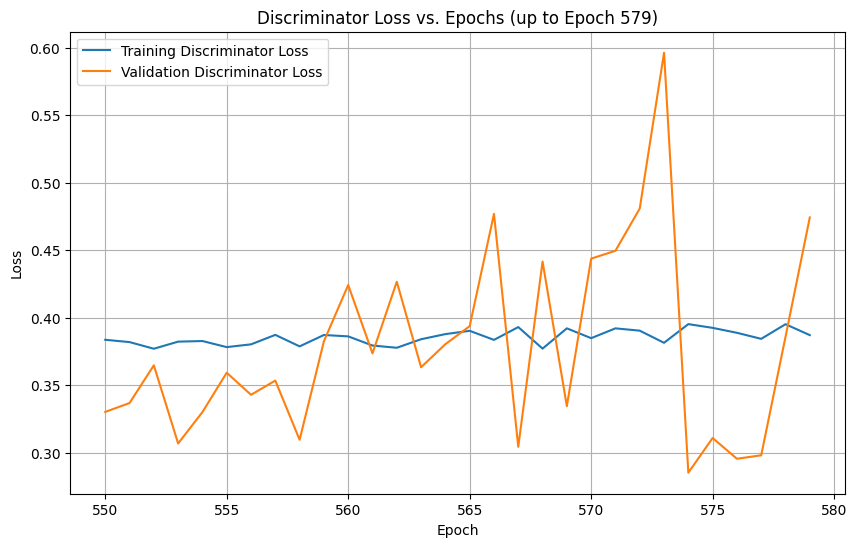

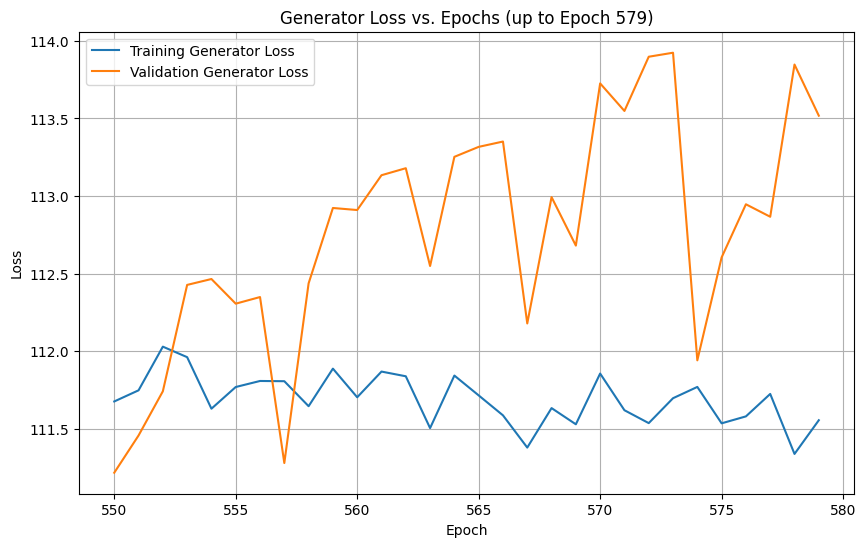

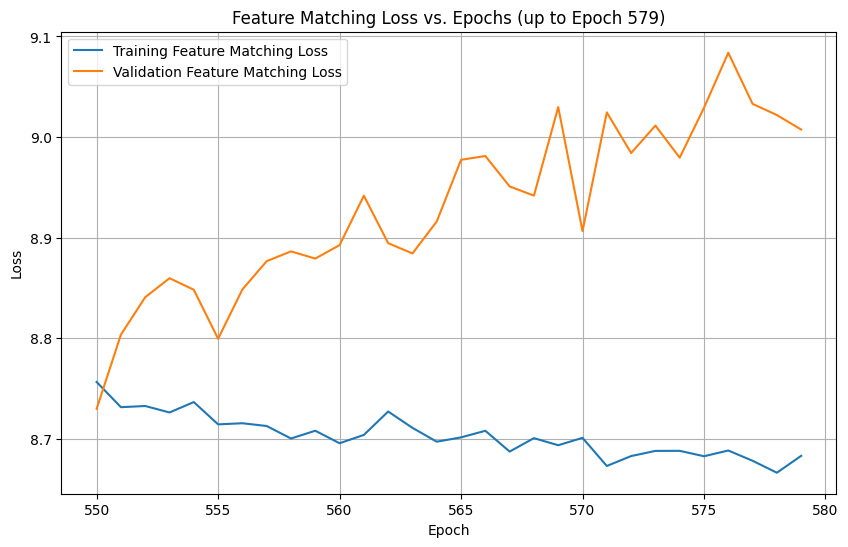

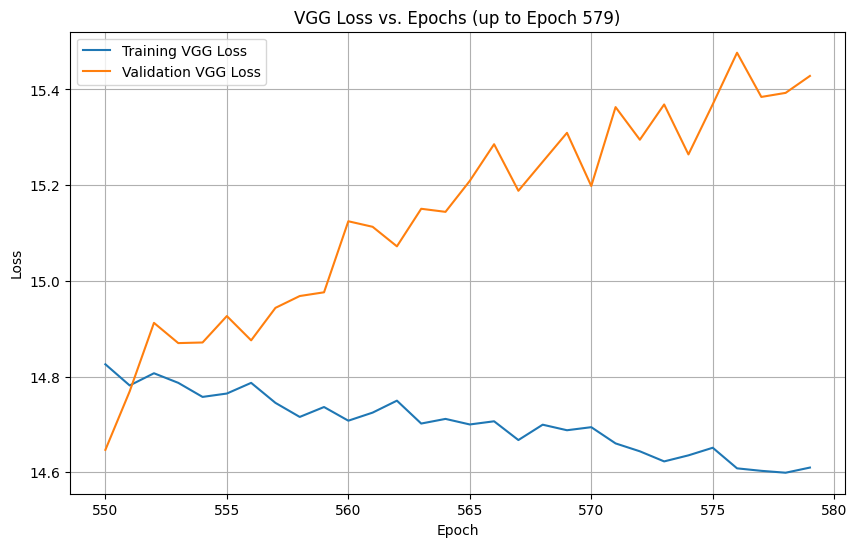

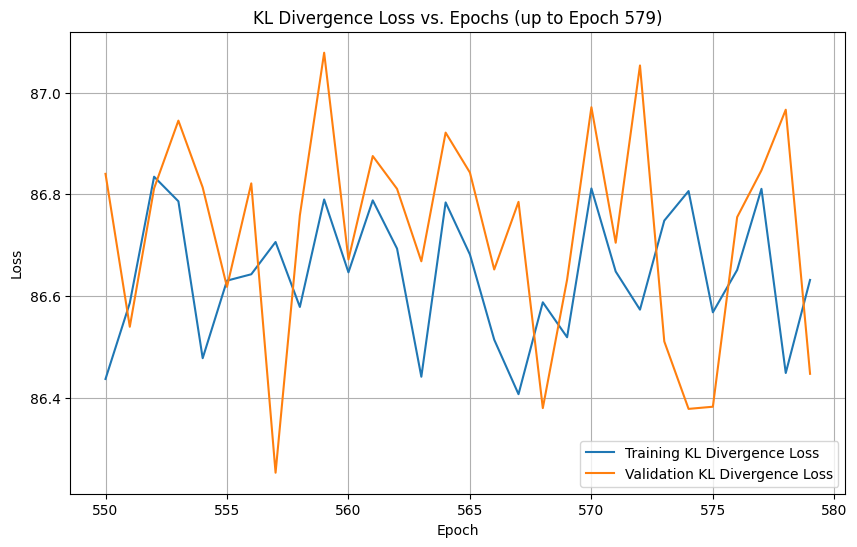

582/582 ━━━━━━━━━━━━━━━━━━━━ 513s 817ms/step - disc_loss: 0.3796 - feat_loss: 8.7047 - gen_loss: 111.5959 - kl_loss: 86.5707 - vgg_loss: 14.6655 - val_disc_loss: 0.4742 - val_feat_loss: 9.0074 - val_gen_loss: 113.5179 - val_kl_loss: 86.4467 - val_vgg_loss: 15.4282
Epoch 581/600
329/582 ━━━━━━━━━━━━━━━━━━━━ 2:55 695ms/step - disc_loss: 0.3809 - feat_loss: 8.6941 - gen_loss: 112.0092 - kl_loss: 86.9939 - vgg_loss: 14.6692

In [ ]:
# ⏳ Total epochs you want to train for
epochs_to_train = 50  # e.g., from epoch 15 to epoch 64

# 🧠 Start from epoch 15
start_epoch = 550

# ✅ Define checkpoint callback (with trash cleanup)
checkpoint_callback = DynamicCheckpoint(
    save_dir="/content/drive/MyDrive/gaugan_checkpoints",
    start_epoch=start_epoch
)
# ✅ Define the new plotting callback
# It will plot graphs every 10 epochs
plotter_callback = PlotLossesCallback(start_epoch=start_epoch, frequency=10)


# 🏋️‍♀️ Continue training from epoch 15 onwards
history = gaugan.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=start_epoch + epochs_to_train,  # 15 + 50 = 65
    initial_epoch=start_epoch,             # resume from epoch 15
    callbacks=[
        GanMonitor(val_dataset, BATCH_SIZE),
        checkpoint_callback,
        plotter_callback
    ]
)

## Inference

In [ ]:
import os
from keras.models import load_model

# Mount drive
from google.colab import drive
drive.mount('/content/drive')

# Set checkpoint path
checkpoint_path = "/content/drive/MyDrive/gaugan_checkpoints/gaugan_epoch_521.weights.h5"


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 2. Create and compile the model
gaugan = GauGAN(IMG_HEIGHT, NUM_CLASSES, BATCH_SIZE, latent_dim=256)
gaugan.compile()

In [ ]:
# Build the model by running a dummy inference
dummy_latent = tf.random.normal((BATCH_SIZE, 256))
dummy_label = tf.random.normal((BATCH_SIZE, IMG_HEIGHT, IMG_WIDTH, NUM_CLASSES))
dummy_image = tf.random.normal((BATCH_SIZE, IMG_HEIGHT, IMG_WIDTH, 3))

# Call once to build internal layers
_ = gaugan([dummy_latent, dummy_label])
_ = gaugan.combined_model([dummy_latent, dummy_label, dummy_image])
_ = gaugan.encoder(dummy_image)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'gau_gan_3', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


In [ ]:
gaugan.load_weights(checkpoint_path)


In [ ]:
generated_images = []
ground_truth_images = []
label_maps = []

for batch in val_dataset:
    segmentation_map, real_image, labels = batch
    mean, var = gaugan.encoder(real_image)
    latent = gaugan.sampler([mean, var])
    fake_image = gaugan.generator([latent, labels])

    generated_images.append(fake_image.numpy())
    ground_truth_images.append(real_image.numpy())
    label_maps.append(tf.argmax(labels, axis=-1).numpy())  # shape: (B, H, W)


In [ ]:
import numpy as np

generated_images = np.concatenate(generated_images)
ground_truth_images = np.concatenate(ground_truth_images)
label_maps = np.concatenate(label_maps)


In [ ]:
output_base = "/content/drive/MyDrive/gaugan_eval_outputs_new"

gen_dir = os.path.join(output_base, "generated_images")
real_dir = os.path.join(output_base, "ground_truth_images")
label_dir = os.path.join(output_base, "label_maps")

os.makedirs(gen_dir, exist_ok=True)
os.makedirs(real_dir, exist_ok=True)
os.makedirs(label_dir, exist_ok=True)


In [ ]:
from PIL import Image

def save_images(images, folder, prefix="img"):
    for i, img in enumerate(images):
        img = ((img + 1.0) * 127.5).astype(np.uint8)  # [-1, 1] to [0, 255]
        Image.fromarray(img).save(os.path.join(folder, f"{prefix}_{i:04d}.png"))


In [ ]:
from PIL import Image
import os

def save_images(images, folder, prefix="img"):
    for i, img in enumerate(images):
        img = ((img + 1.0) * 127.5).astype(np.uint8)
        Image.fromarray(img).save(os.path.join(folder, f"{prefix}_{i:04d}.png"))

def save_label_maps(label_maps, folder):
    for i, label in enumerate(label_maps):
        img = Image.fromarray(label.astype(np.uint8))
        img.save(os.path.join(folder, f"label_{i:04d}.png"))

# Now call these
save_images(generated_images, gen_dir, prefix="gen")
save_images(ground_truth_images, real_dir, prefix="real")
save_label_maps(label_maps, label_dir)


In [ ]:
!pip install -q clean-fid


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 114.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 96.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 60.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 104.3 MB/s eta 0:00:00


## FID Score

In [ ]:
from cleanfid import fid

real_path = "/content/drive/MyDrive/gaugan_eval_outputs_new/ground_truth_images"
fake_path = "/content/drive/MyDrive/gaugan_eval_outputs_new/generated_images"

fid_score = fid.compute_fid(real_path, fake_path)
print(f"✅ FID Score: {fid_score:.4f}")


compute FID between two folders


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Found 580 images in the folder /content/drive/MyDrive/gaugan_eval_outputs_new/ground_truth_images


FID ground_truth_images : 100%|██████████| 19/19 [00:22<00:00,  1.17s/it]


Found 580 images in the folder /content/drive/MyDrive/gaugan_eval_outputs_new/generated_images


FID generated_images : 100%|██████████| 19/19 [00:22<00:00,  1.17s/it]


✅ FID Score: 81.1465


In [ ]:
%pip install tensorflow_hub


In [ ]:
!pip install -q torch torchvision pillow


In [ ]:
import torch
from torchvision import models, transforms
from PIL import Image
import numpy as np

model = models.segmentation.deeplabv3_resnet50(pretrained=True)
model.eval()


DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [ ]:
preprocess = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

def predict_mask_torch(img_path):
    img = Image.open(img_path).convert("RGB")
    input_tensor = preprocess(img).unsqueeze(0)  # shape: (1,3,256,256)

    with torch.no_grad():
        output = model(input_tensor)['out'][0]  # shape: (21,256,256)
    pred = output.argmax(0).cpu().numpy().astype(np.uint8)  # (256,256) labels 0–20
    return pred


In [ ]:
gen_dir = "/content/drive/MyDrive/gaugan_eval_outputs_new/generated_images"
label_dir = "/content/drive/MyDrive/gaugan_eval_outputs_new/label_maps"

num_images = len(os.listdir(gen_dir))
preds, gts = [], []

for i in range(num_images):
    preds.append(predict_mask_torch(os.path.join(gen_dir, f"gen_{i:04d}.png")))
    gts.append(np.array(Image.open(os.path.join(label_dir, f"label_{i:04d}.png"))))

preds = np.stack(preds)
gts = np.stack(gts)


## MIOU and Pixel Accuracy Score

In [ ]:
import numpy as np

def compute_metrics(preds, gts, num_classes=21):
    ious = []
    total_correct = 0
    total_pixels = 0

    for cls in range(num_classes):
        pred_inds = (preds == cls)
        gt_inds = (gts == cls)

        intersection = np.logical_and(pred_inds, gt_inds).sum()
        union = np.logical_or(pred_inds, gt_inds).sum()

        if union > 0:
            iou = intersection / union
            ious.append(iou)

    total_correct = (preds == gts).sum()
    total_pixels = np.prod(preds.shape)

    miou = np.mean(ious)
    pixel_acc = total_correct / total_pixels

    return miou, pixel_acc

miou, pix_acc = compute_metrics(preds, gts)
print(f"✅ mIoU: {miou:.4f}, Pixel Accuracy: {pix_acc:.4f}")


✅ mIoU: 0.348, Pixel Accuracy: 0.7044
